
<h1><center>Position Classification for FC Barcelona's Youth Players</center></h3>
<center><img src="https://static01.nyt.com/athletic/uploads/wp/2024/04/19073705/1116_LaMasia-scaled.jpg?width=400&height=400&fit=cover"></center>

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:brown; border:0; color:white' role="tab" aria-controls="home"><center>Quick navigation</center></h3>

* [1. Exploratory Data Analysis](#1)
* [2. Target Column Analysis](#2)
* [3. Categorical Data Analysis](#3)
* [4. Numerical Data Analysis](#4)
* [5. Missing Values Imputation](#5)
* [6. Outlier Processing](#6)
* [7. Feature Engineering](#7)
* [8. Categorical Encoding](#8)
* [9. Dropping Unnecessary Columns](#9)
* [10. Building Pipeline Function](#10)
* [11. Building Model / Testing](#11)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, r2_score

from pathlib import Path
import os

### Creating current working directory since the spicifics. of .ipynb

In [2]:
CWD = os.path.abspath('')

<a id="1"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Exploratory Data Analysis</center></h3>

In [3]:
def get_data(ds_type: str) -> pd.DataFrame:
    """
    Getting data

    :param ds_type: train / test
    """
    path = Path(CWD).parent / f'data/{ds_type}.csv'
    
    return pd.read_csv(path)

In [4]:
def calculate_nan_values(data: pd.DataFrame) -> pd.DataFrame:
    """
    Function to calculate number and % of nan values in data

    :param data: Input Dataset
    """
    nan_counts = data.isna().sum()
    nan_counts_percent = (data.isna().sum() / len(data)) * 100

    nan_summary = pd.DataFrame({
        'NaN Count': nan_counts,
        'NaN Percent': nan_counts_percent
    })

    nan_summary = nan_summary[nan_summary['NaN Count'] > 0]
    nan_summary = nan_summary.sort_values(by='NaN Count', ascending=False)

    return nan_summary


In [5]:
def plot_nan_info(nan_info: pd.DataFrame, dataset_type: str) -> plt.Axes:
    """
    Plot nan insights
    
    :param nan_info: Nan DataSet
    :param dataset_type: train / test 
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(nan_info.index, nan_info['NaN Percent'], color='coral', edgecolor='black')
    
    ax.set_xlabel('columns', fontsize=14)
    ax.set_ylabel('NaN %', fontsize=14)
    ax.set_title(f'percentage of NaN Values for {dataset_type}', fontsize=16)
    ax.set_xticks(range(len(nan_info.index)))
    ax.set_xticklabels(nan_info.index, rotation=45, ha='right', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return ax


In [6]:
def preprocess_nan(data: pd.DataFrame, dataset_type: str, plot: bool = True, threshold: int = 85) -> pd.DataFrame:
    """
    Cleans data from nan values

    :param data: Input Dataset
    :param dataset_type: train / test
    :param plot: True to plot info 
    :param threshold: % of nan in a column to be dropped [0-100]
    """
    nan_summary_initial = calculate_nan_values(data)

    initial_lenght = len(data.columns)
    columns_to_drop = nan_summary_initial[nan_summary_initial["NaN Percent"] > threshold].index
    data_cleaned = data.drop(columns=columns_to_drop)

    if not plot:
        return data_cleaned

    print(f'{len(columns_to_drop)} (from {initial_lenght} to {len(data_cleaned.columns)}) columns dropped from {dataset_type}')

    nan_summary_cleaned = calculate_nan_values(data_cleaned)

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.bar(
        nan_summary_initial.index, 
        nan_summary_initial['NaN Percent'], 
        color='coral', 
        edgecolor='black', 
        label='Before Cleaning'
    )

    ax.bar(
        nan_summary_cleaned.index, 
        nan_summary_cleaned['NaN Percent'], 
        color='skyblue', 
        edgecolor='black', 
        label='After Cleaning'
    )

    ax.set_xlabel('Columns', fontsize=14)
    ax.set_ylabel('%', fontsize=14)
    ax.set_title(f'Comparison of NaN Values Drop', fontsize=16)
    ax.set_xticks(range(len(nan_summary_initial.index)))
    ax.set_xticklabels(nan_summary_initial.index, rotation=45, ha='right', fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    fig.text(0.5, 0.6, dataset_type, fontsize=40, color='gray', alpha=0.3, ha='center', va='center')   

    plt.tight_layout()
    plt.show()

    return data_cleaned

4 (from 70 to 66) columns dropped from train


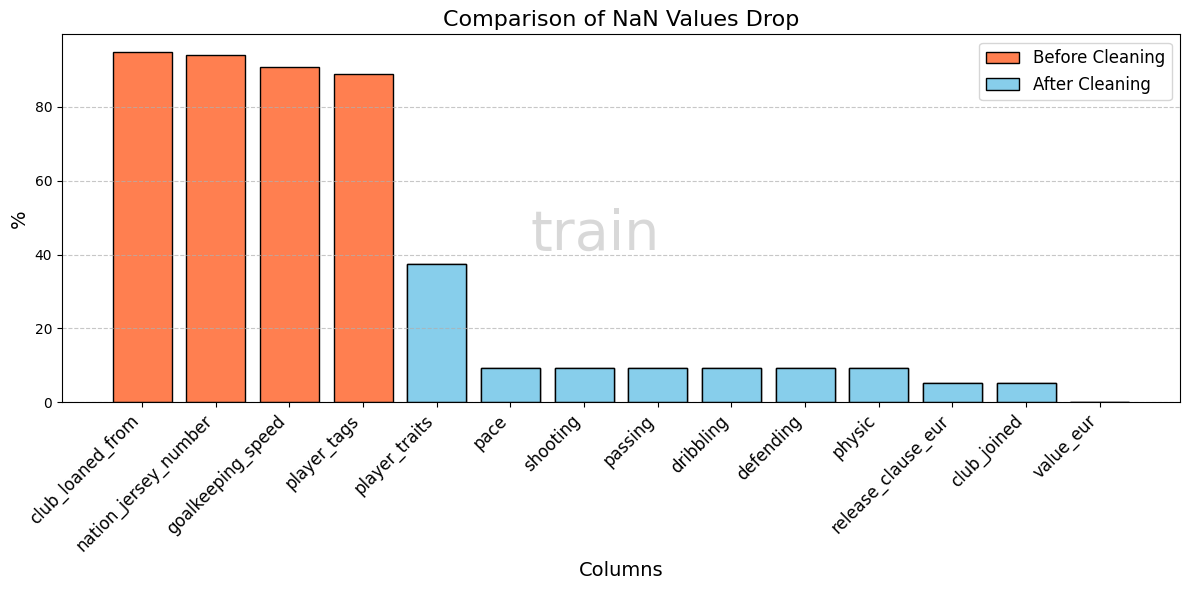

In [7]:
train_data = get_data("train")
train_data = preprocess_nan(data=train_data, dataset_type="train")


<a id="2"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Target column analysis</center></h3>

Since we want to undersatand the distribution of the target column, we need to plot it

In [8]:
def plot_dist(data: pd.DataFrame, column: str) -> None:
    """
    Plots distribution of given column

    :param data: dataset
    :param column: target column
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data[column], 
        kde=True,  
        color='coral', 
        bins=30
    )
    plt.title(f'Distribution of {column.capitalize()}', fontsize=16)
    plt.xlabel(column.capitalize(), fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

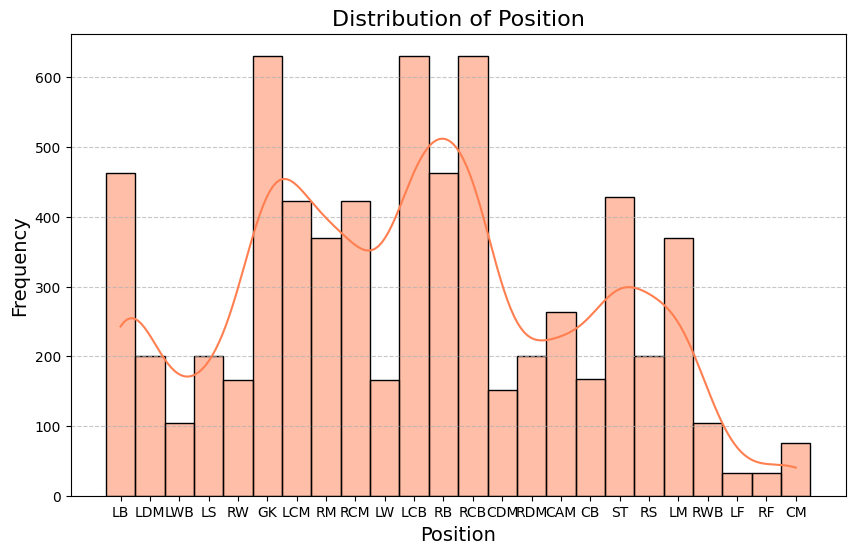

In [9]:
plot_dist(train_data, "position")

<a id="3"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Categorical Data Analysis</center></h3>

Firstly, we need to undesrtand which values we are working on and which categorical features worth analyzing

In [10]:
for col in train_data.select_dtypes(include=['object', 'category']).columns:
    print(f'Categorical column {col} has {train_data[col].nunique()} unique values')

Categorical column short_name has 6692 unique values
Categorical column birthday_date has 3991 unique values
Categorical column club_name has 701 unique values
Categorical column league_name has 55 unique values
Categorical column club_joined has 1263 unique values
Categorical column nationality_name has 144 unique values
Categorical column preferred_foot has 2 unique values
Categorical column work_rate has 9 unique values
Categorical column body_type has 10 unique values
Categorical column real_face has 2 unique values
Categorical column player_traits has 772 unique values
Categorical column position has 24 unique values


We can see that some of them have couple of Ks unique values. Firstly, it is useless to transform them to numerical view, and moreover, some of them will not give us any insights (e.g.: Club Joined) (supposedly)

However, those who we still need but which have high number of unique values, we need consider to be implemented in another way

In [11]:
def plot_categorical_dist(data: pd.DataFrame, n: int = 10) -> None:
    """
    Plots categorical parameters

    :param n: top n of unique values
    """
    categorical_columns = [
        col for col in data.select_dtypes(include=['object', 'category']).columns
    ]

    n_cols = 3
    n_rows = (len(categorical_columns) + n_cols - 1) // n_cols 

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
    axes = axes.flatten() 

    for i, col in enumerate(categorical_columns):
        top_categories = data[col].value_counts().head(10)

        sns.barplot(
            x=top_categories.index,
            y=top_categories.values,
            hue=top_categories.values,
            ax=axes[i],
            palette="coolwarm"
        )
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel('Category', fontsize=12)
        axes[i].set_ylabel('Frequency', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(len(categorical_columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

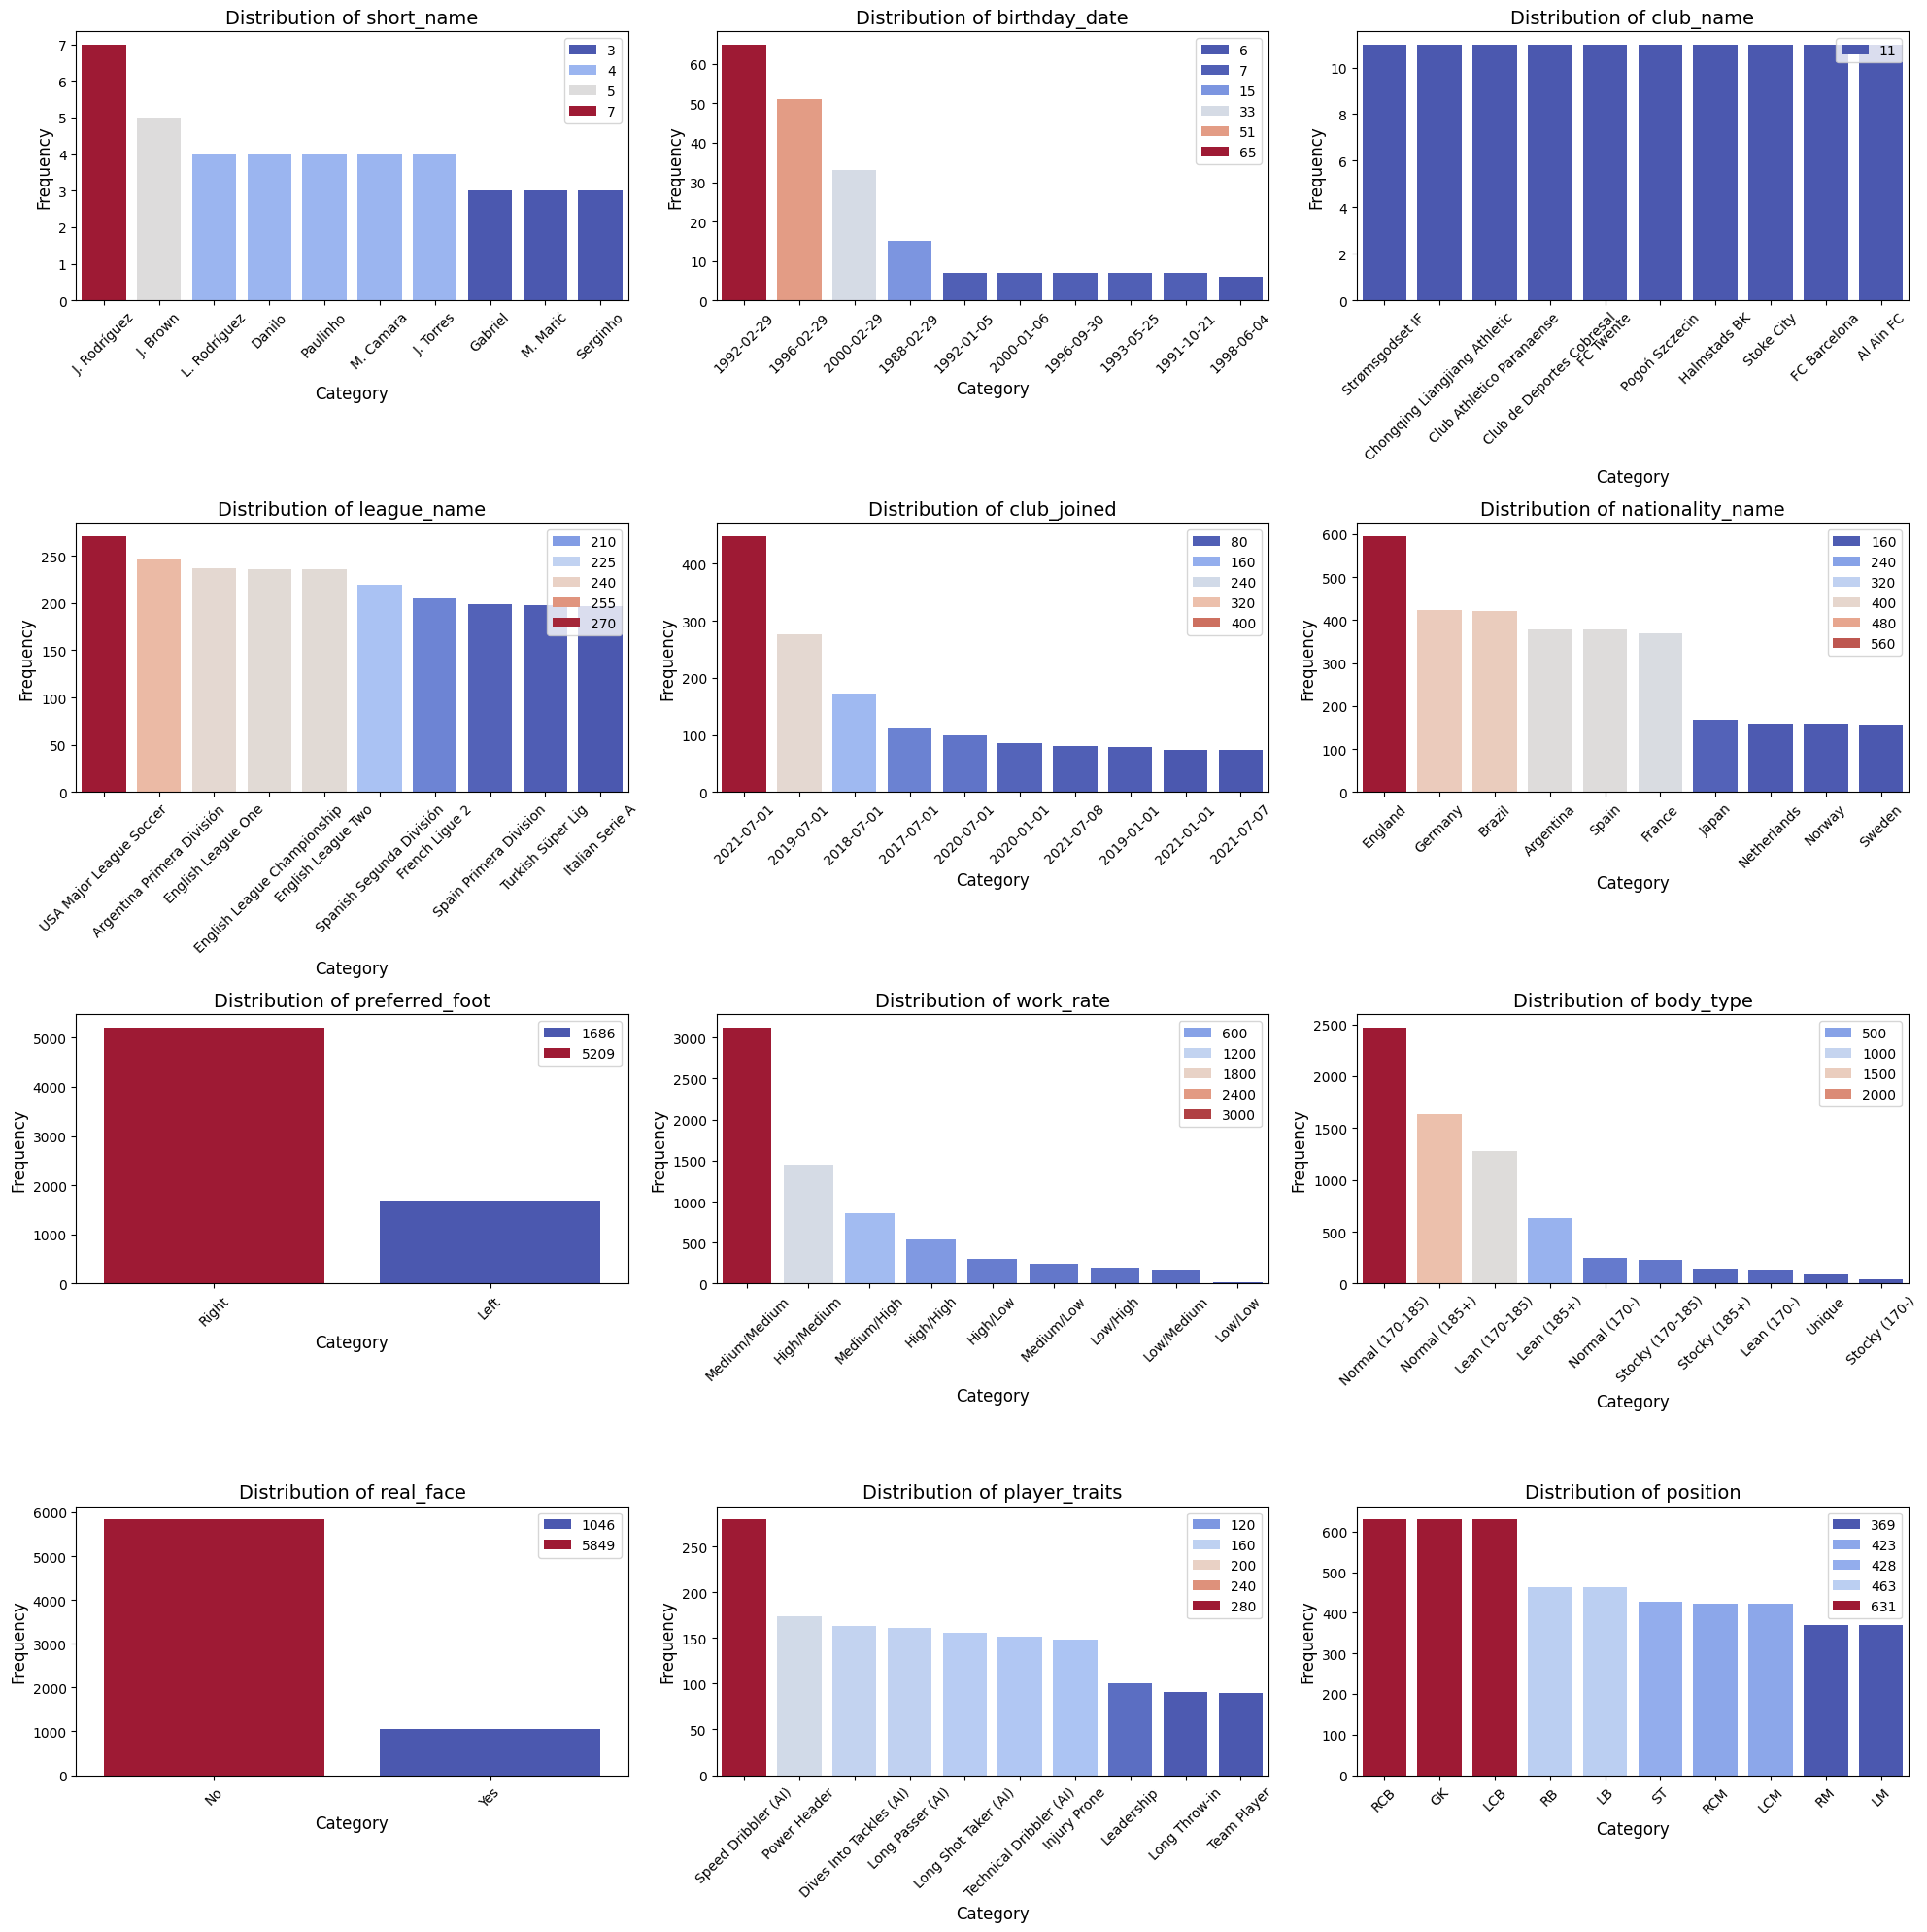

In [12]:
plot_categorical_dist(data=train_data)

<a id="4"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Numerical Data Analysis</center></h3>

In [13]:
numeric_columns = train_data.select_dtypes(include=['float64', 'int64']).columns

train_data[numeric_columns].describe()

,id,overall,potential,value_eur,wage_eur,height_cm,weight_kg,league_level,club_jersey_number,club_contract_valid_until,...,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,6895.000000,6895.000000,6895.000000,6.893000e+03,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,...,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000
mean,223463.552719,68.825671,72.031327,4.320388e+06,12034.126178,181.478898,75.527919,1.361856,16.442350,2022.754605,...,49.883249,61.875997,51.281653,52.249021,49.736766,15.897317,15.690210,15.558666,15.819144,16.003046
std,26876.952793,5.950459,6.070890,1.052554e+07,24630.820430,6.862683,7.041120,0.760018,15.440185,1.204310,...,15.663569,10.937084,19.654312,20.898714,20.613351,17.451010,16.752522,16.316593,17.159677,17.854369
min,41.000000,49.000000,53.000000,2.500000e+04,500.000000,156.000000,53.000000,1.000000,1.000000,2021.000000,...,8.000000,12.000000,4.000000,5.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,207602.500000,65.000000,68.000000,7.250000e+05,2000.000000,177.000000,70.000000,1.000000,6.000000,2022.000000,...,40.000000,56.000000,35.000000,34.000000,31.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,227951.000000,68.000000,72.000000,1.400000e+06,4000.000000,182.000000,75.000000,1.000000,13.000000,2023.000000,...,50.000000,63.000000,58.000000,61.000000,58.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,242423.500000,72.000000,76.000000,2.900000e+06,12000.000000,186.000000,80.000000,1.000000,22.000000,2024.000000,...,62.000000,69.000000,66.000000,68.000000,66.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,264481.000000,93.000000,95.000000,1.940000e+08,350000.000000,203.000000,103.000000,5.000000,99.000000,2028.000000,...,93.000000,96.000000,90.000000,93.000000,92.000000,91.000000,92.000000,91.000000,92.000000,90.000000


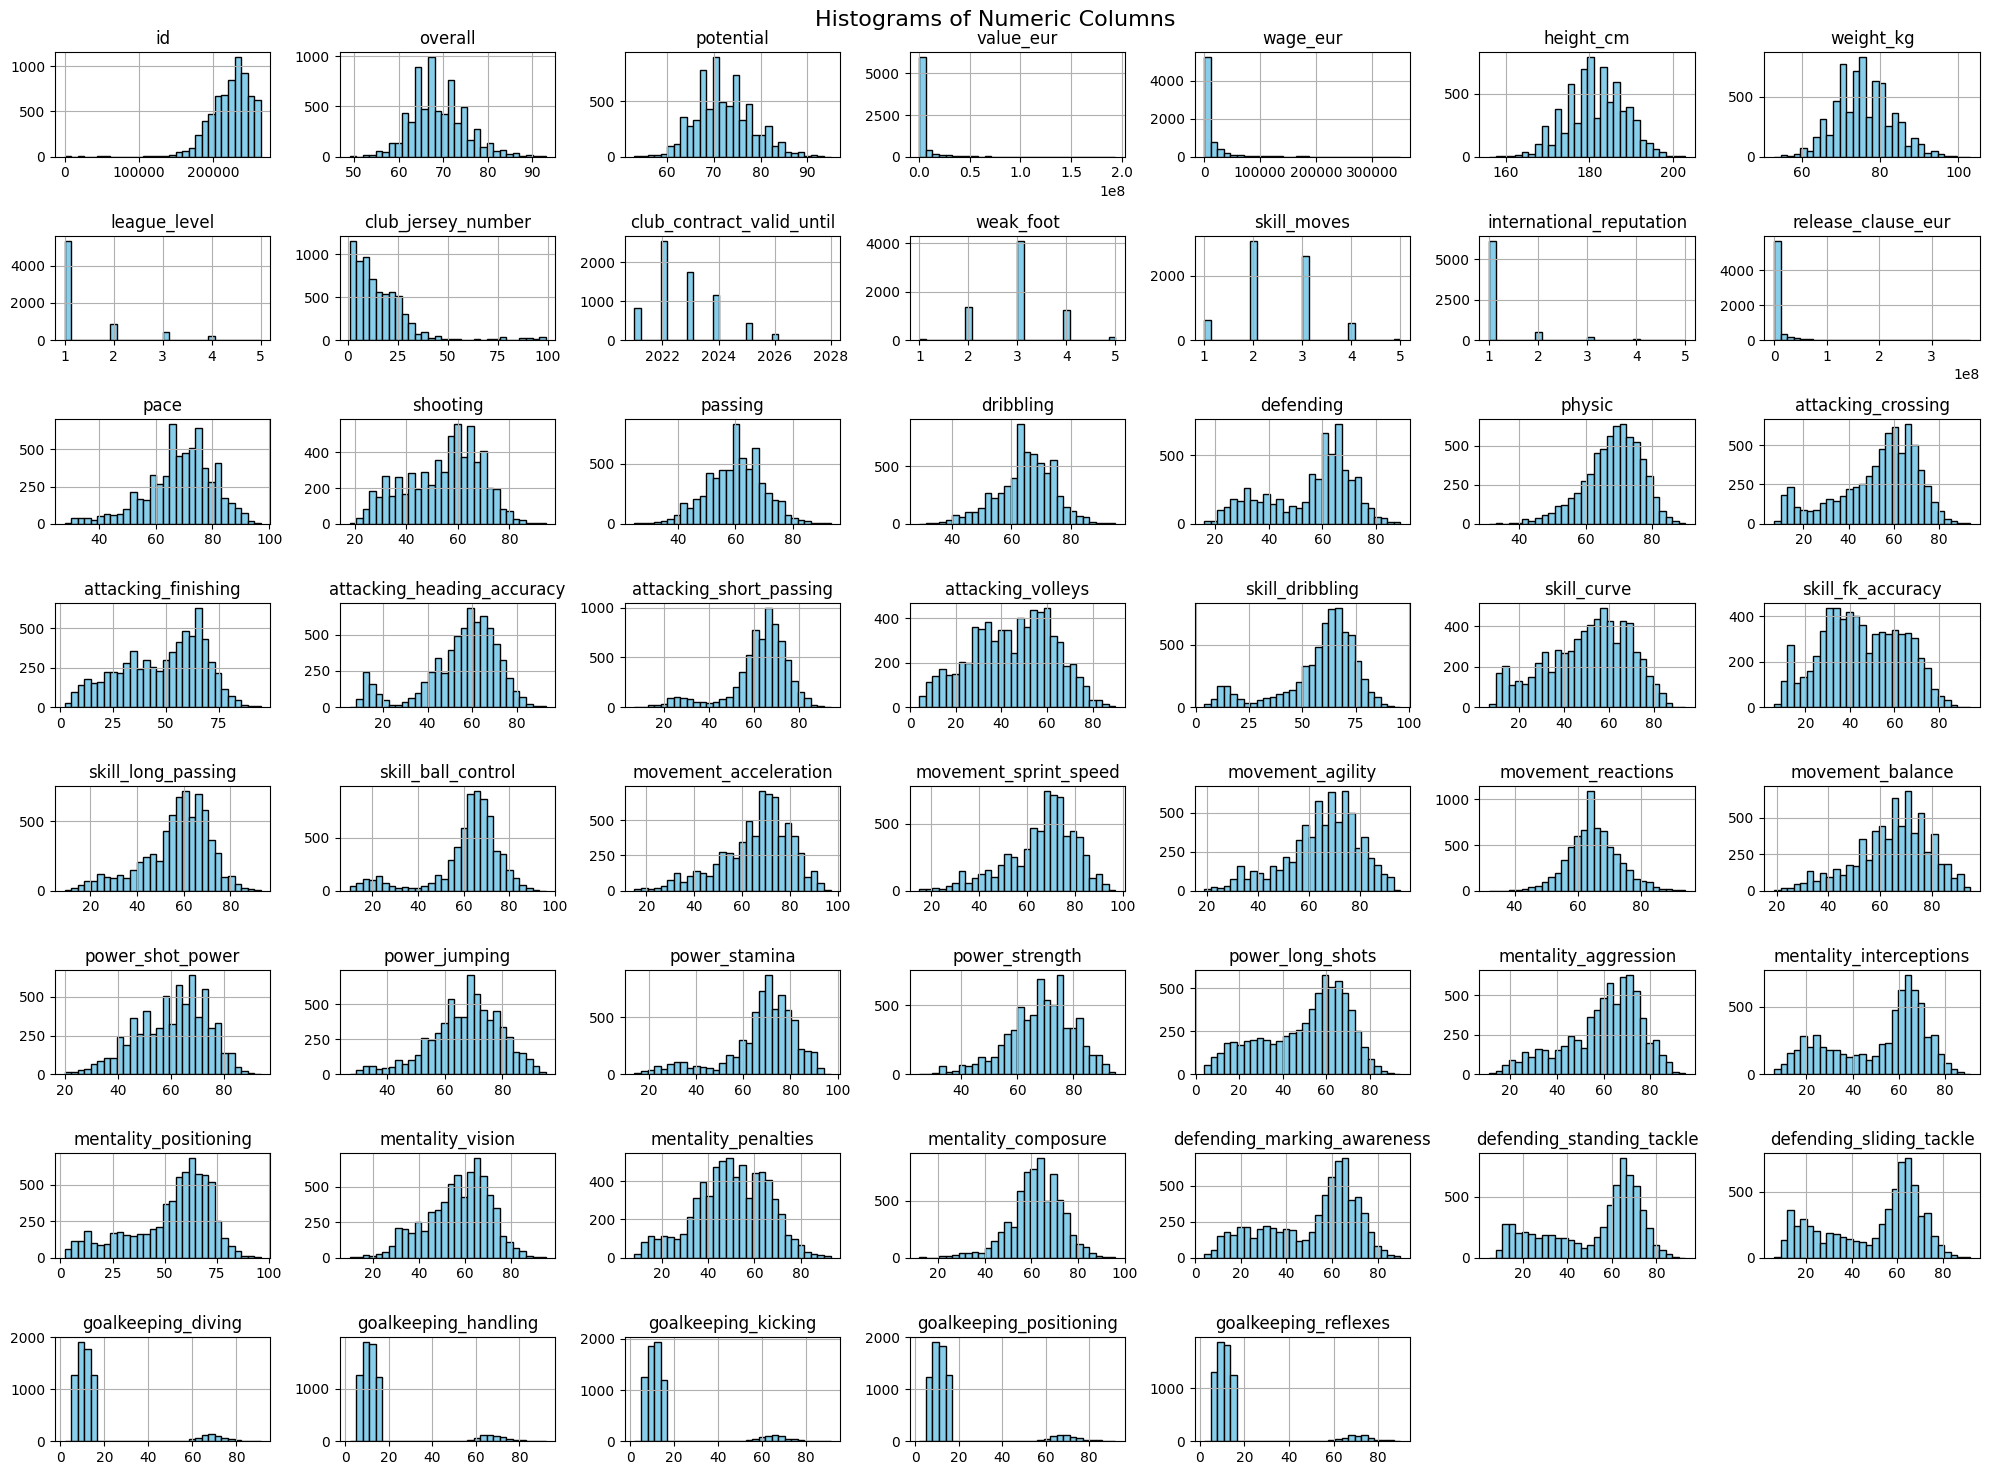

In [14]:
train_data[numeric_columns].hist(bins=30, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Numeric Columns', fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
correlation_matrix = train_data[numeric_columns].corr()

# Since we have a lot of variables, we need to extract only those, what have high correaltion
correlation_threshold = 0.9

correlated_pairs = []

for col in correlation_matrix.columns:
    for idx in correlation_matrix.index:
        if col != idx and abs(correlation_matrix.loc[idx, col]) > correlation_threshold:
            correlated_pairs.append((idx, col, correlation_matrix.loc[idx, col]))

correlated_pairs_df = pd.DataFrame(correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
correlated_pairs_df = correlated_pairs_df.drop_duplicates()

print("Highly correlated pairs:")
print(correlated_pairs_df)

Highly correlated pairs:
                  Feature 1                Feature 2  Correlation
0        release_clause_eur                value_eur     0.995700
1                 value_eur       release_clause_eur     0.995700
2     movement_acceleration                     pace     0.962618
3     movement_sprint_speed                     pace     0.974853
4       attacking_finishing                 shooting     0.968797
..                      ...                      ...          ...
57     goalkeeping_reflexes  goalkeeping_positioning     0.972248
58       goalkeeping_diving     goalkeeping_reflexes     0.973463
59     goalkeeping_handling     goalkeeping_reflexes     0.971948
60      goalkeeping_kicking     goalkeeping_reflexes     0.967557
61  goalkeeping_positioning     goalkeeping_reflexes     0.972248

[62 rows x 3 columns]


<a id="5"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Missing Values Imputation</center></h3>

In [16]:
def fill_nan_with_reg(data: pd.DataFrame, column: str, correlation_matrix: pd.DataFrame, corr_threshold: float = 0.8) -> pd.DataFrame:
    """
    Function fills NaN values with regression, regressors of which is highly correlated columns

    :param data: train / test
    :param column: column with NaN
    :param correaltion matrix: correlation matrix where column to be fiiled exists
    :param corr_threshold: value which is gonna be chosen for correalted variables
    """
    inital_nan = data[column].isna().sum()
    if column not in correlation_matrix.columns:
        raise ValueError(f"Column '{column}' not found in correlation matrix.")
    
    features = correlation_matrix[column][abs(correlation_matrix[column]) > corr_threshold].index.tolist()

    correlated_features = [column]
    for feature in features:
        if len(correlated_features) >= 4:
            break
        if data[feature].isna().sum() == 0:
            correlated_features.append(feature)
    
    print(correlated_features)
    
    correlated_features.remove(column)

    if not correlated_features:
        raise ValueError(f"No features with correlation above {corr_threshold} for column '{column}'.")

    print(f"Highly correlated features with '{column}': {correlated_features}")

    data_with_values = data[~data[column].isna()]
    data_with_nan = data[data[column].isna()]
    
    if data_with_values.empty:
        raise ValueError(f"No non-NaN rows found for column '{column}' to train regression model.")
    
    X = data_with_values[correlated_features]
    y = data_with_values[column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    print(f'Filled {inital_nan} with R^2 score of {r2:.4f}')
    
    predicted_values = model.predict(data_with_nan[correlated_features])
    data.loc[data[column].isna(), column] = predicted_values
    
    return data[column]

In [17]:
def fill_nan_with_mean(data: pd.DataFrame, column: str) -> pd.DataFrame:
    data[column] = data[column].fillna(data[column].mean())
    
    return data[column]

In [18]:
nan_counts = train_data.isna().sum()

columns_with_nan = nan_counts[nan_counts > 0]
print(columns_with_nan)


value_eur                2
club_joined            351
release_clause_eur     353
player_traits         2589
pace                   631
shooting               631
passing                631
dribbling              631
defending              631
physic                 631
dtype: int64


In [19]:
numeric_columns = train_data.select_dtypes(include=["float64", "int64"]).columns

for column in numeric_columns:
    if train_data[column].isna().sum() > 0:
        train_data[column] = fill_nan_with_reg(train_data.copy(), column, correlation_matrix.copy(), corr_threshold=0.8)

nan_counts = train_data.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
print(columns_with_nan)

['value_eur', 'wage_eur']
Highly correlated features with 'value_eur': ['wage_eur']
Filled 2 with R^2 score of 0.7338
['release_clause_eur', 'value_eur', 'wage_eur']
Highly correlated features with 'release_clause_eur': ['value_eur', 'wage_eur']
Filled 353 with R^2 score of 0.9926
['pace', 'movement_acceleration', 'movement_sprint_speed']
Highly correlated features with 'pace': ['movement_acceleration', 'movement_sprint_speed']
Filled 631 with R^2 score of 0.9994
['shooting', 'attacking_finishing', 'attacking_volleys', 'power_shot_power']
Highly correlated features with 'shooting': ['attacking_finishing', 'attacking_volleys', 'power_shot_power']
Filled 631 with R^2 score of 0.9884
['passing', 'attacking_crossing', 'attacking_short_passing', 'skill_curve']
Highly correlated features with 'passing': ['attacking_crossing', 'attacking_short_passing', 'skill_curve']
Filled 631 with R^2 score of 0.9612
['dribbling', 'passing', 'skill_dribbling', 'skill_ball_control']
Highly correlated featur

<a id="6"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Outlier Processing</center></h3>

In [20]:
def remove_outliers(df, method='zscore', threshold=3):
    """
    Function removes outliers with two methods by selection, zscore or iqr
    """
    df_cleaned = df.copy()
    numeric_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

    if method == 'zscore':
        for col in numeric_columns:
            mean = df_cleaned[col].mean()
            std = df_cleaned[col].std()
            z_scores = (df_cleaned[col] - mean) / std
            df_cleaned = df_cleaned[np.abs(z_scores) <= threshold]
    
    elif method == 'iqr':
        for col in numeric_columns:
            q1 = df_cleaned[col].quantile(0.25)
            q3 = df_cleaned[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - threshold * iqr
            upper_bound = q3 + threshold * iqr
            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    
    return df_cleaned

In [21]:
# Checking how many rows were excluded

before_preprocessing_length = len(train_data)

train_data = remove_outliers(train_data, "zscore", 4)

print(f'Changed from {before_preprocessing_length} to {len(train_data)}')

Changed from 6895 to 6332


<a id="7"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Feature Engineering</center></h3>

In [22]:
def put_primary_priority_skill(data: pd.DataFrame, skill_pool: list[str]) -> pd.DataFrame:
    """
    Function inserts a column with the highest skill from the given pool
    """
    data["priority_skill"] = data[skill_pool].idxmax(axis=1)
    
    return data

In [23]:
def calculate_position_priority_skill(data: pd.DataFrame) -> pd.DataFrame:
    """
    Function gathers all the data for columns with given prefixes and calculates it's average. 

    Higher Average gets a statts of "position_priority_skill"
    """
    prefixes = {
        'attacking': [col for col in data.columns if col.startswith('attacking')],
        'defending': [col for col in data.columns if col.startswith('defending')],
        'goalkeeping': [col for col in data.columns if col.startswith('goalkeeping')]
    }
    
    for prefix, cols in prefixes.items():
        data[f'{prefix}_avg'] = data[cols].mean(axis=1)
    
    avg_columns = [f'{prefix}_avg' for prefix in prefixes.keys()]
    data['position_priority_skill'] = data[avg_columns].idxmax(axis=1).str.replace('_avg', '', regex=False)
    
    data.drop(columns=avg_columns, inplace=True)
    
    return data

In [24]:
def put_secondary_priority_skill(data: pd.DataFrame) -> pd.DataFrame:
    """
    Same methodology as in put_primary_priority_skill function
    """
    groups = {
        'movement': [col for col in data.columns if col.startswith('movement')],
        'power': [col for col in data.columns if col.startswith('power')],
        'mentality': [col for col in data.columns if col.startswith('mentality')]
    }
    
    for group_name, columns in groups.items():
        data[f'{group_name}_priority_skill'] = data[columns].idxmax(axis=1)
    
    return data

In [25]:
# Testing

train_data = get_data("train")

print(train_data.shape)

columns = [
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending"
]

train_data = put_primary_priority_skill(train_data, columns)

train_data = put_secondary_priority_skill(train_data)

train_data["movement_priority_skill"]

(6895, 70)


/var/folders/_k/4jmlcdh94fn8f_g2j15scs2m0000gn/T/ipykernel_30930/3395839567.py:5: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  data["priority_skill"] = data[skill_pool].idxmax(axis=1)


0            movement_agility
1            movement_balance
2       movement_acceleration
3          movement_reactions
4       movement_sprint_speed
                ...          
6890    movement_acceleration
6891         movement_balance
6892    movement_acceleration
6893         movement_agility
6894       movement_reactions
Name: movement_priority_skill, Length: 6895, dtype: object

In [26]:
def one_hot_trait_encode(data: pd.DataFrame, useful_traits: list[str]) -> pd.DataFrame:
    for trait in useful_traits:
        data[trait] = data['player_traits'].str.contains(trait, case=False, na=False).astype(int)
        
    return data

In [27]:
def delete_high_corr(data: pd.DataFrame, threshold: float = 0.9) -> pd.DataFrame:
    """
    Function deletes columns with high correaltions. Since it is not a must in context of classification, this implemetation is arguable
    """
    import numpy as np

    numeric_cols = data.select_dtypes(include=[np.number]).columns

    corr_matrix = data[numeric_cols].corr().abs()

    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    print(f"Deleted {len(to_drop)} columns with corr > {threshold}:")
    for col in to_drop:
        print(f"- {col}")

    data_reduced = data.drop(columns=to_drop)

    return data_reduced

In [28]:
def tranform_age(data: pd.DataFrame, input_column: str, output: str, age_type: str) -> pd.DataFrame:
    """
    Transforming any date to age.
    """
    data[input_column] = pd.to_datetime(data[input_column])

    data[output] = pd.Timestamp.now().year - data[input_column].dt.year

    data.drop(columns=[input_column], inplace=True)

    return data

In [29]:
def split_height_and_type(column):
    height = column.str.extract(r'\((\d+[-\+]\d*)\)')[0]
    body_type = column.str.extract(r'^(\w+)')[0]
    return height, body_type

In [30]:
def preprocess_features(data: pd.DataFrame) -> pd.DataFrame:
    "Function does feature engineering for ages and body"
    data = tranform_age(data=data, input_column="birthday_date", output="age", age_type="birthday")

    data = tranform_age(data=data, input_column="club_joined", output="club_age", age_type="club")

    _, data["body_type_cleaned"] = split_height_and_type(data["body_type"])

    return data

In [31]:

print(train_data.isnull().sum())

train_data = preprocess_features(train_data.copy())

print(train_data.isnull().sum())

train_data["club_age"]

id                            0
short_name                    0
overall                       0
potential                     0
value_eur                     2
                           ... 
position                      0
priority_skill              631
movement_priority_skill       0
power_priority_skill          0
mentality_priority_skill      0
Length: 74, dtype: int64
id                            0
short_name                    0
overall                       0
potential                     0
value_eur                     2
                           ... 
power_priority_skill          0
mentality_priority_skill      0
age                           0
club_age                    351
body_type_cleaned             0
Length: 75, dtype: int64


0       3.0
1       3.0
2       3.0
3       6.0
4       5.0
       ... 
6890    3.0
6891    3.0
6892    4.0
6893    9.0
6894    3.0
Name: club_age, Length: 6895, dtype: float64

<a id="8"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Categorical Encoding</center></h3>

In [32]:
from sklearn.preprocessing import LabelEncoder

def label_encode(column: pd.Series):
    le = LabelEncoder()

    return le.fit_transform(column)

In [33]:
def transform_cat_to_num(data: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    le = LabelEncoder()
    for column in columns:
        if column in data.columns and column != "position":
            print(f'Tranforming {column} ({len(data[column].unique())} unique values) to label columns')
            data[column] = le.fit_transform(data[column])

    return data

<a id="9"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Dropping Unnecessary Columns</center></h3>

In [34]:
train_data = train_data.drop(columns=["player_traits", "nationality_name", "club_name", "short_name", "league_name", "id"])

In [35]:
categorical_columns = train_data.select_dtypes(include=['object']).columns

train_data = transform_cat_to_num(train_data, categorical_columns)

Tranforming club_loaned_from (197 unique values) to label columns
Tranforming preferred_foot (2 unique values) to label columns
Tranforming work_rate (9 unique values) to label columns
Tranforming body_type (10 unique values) to label columns
Tranforming real_face (2 unique values) to label columns
Tranforming player_tags (62 unique values) to label columns
Tranforming priority_skill (6 unique values) to label columns
Tranforming movement_priority_skill (5 unique values) to label columns
Tranforming power_priority_skill (5 unique values) to label columns
Tranforming mentality_priority_skill (6 unique values) to label columns
Tranforming body_type_cleaned (4 unique values) to label columns


In [36]:
train_data.head()

,overall,potential,value_eur,wage_eur,height_cm,weight_kg,league_level,club_jersey_number,club_loaned_from,club_contract_valid_until,...,goalkeeping_reflexes,goalkeeping_speed,position,priority_skill,movement_priority_skill,power_priority_skill,mentality_priority_skill,age,club_age,body_type_cleaned
0,71,71,1400000.0,10000,176,73,1,29,196,2026,...,12,NaN,LB,2,1,3,2,35,3.0,1
1,65,71,1000000.0,2000,183,73,1,4,196,2022,...,11,NaN,LDM,2,2,3,0,28,3.0,0
2,65,77,1600000.0,2000,178,69,1,19,196,2026,...,11,NaN,LWB,2,0,3,0,23,3.0,1
3,72,72,2300000.0,5000,188,81,1,9,196,2023,...,9,NaN,LS,4,3,4,4,32,6.0,0
4,65,65,525000.0,3000,179,74,1,30,196,2022,...,15,NaN,LB,2,4,0,2,34,5.0,1


<a id="10"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Building Pipeline Function</center></h3>

### Since our pipeline is custom, we decided to use a custom function (both for train and test)

Since outlier removing shows us poor f1 score as a result, we decided to cancel this implementation

Same for filling nan values with regression, the idea seemed to be reasonable, but it can not merge eith the implemetation of dropping high correalted columns

In [37]:
def preprocess_data(data: pd.DataFrame, dataset_type: str) -> pd.DataFrame:
    # Drop those columns that have to many nan values
    data = preprocess_nan(data=data, dataset_type=dataset_type, plot=False)
    
    # Remove outliers
    # data = remove_outliers(data, "zscore", 4)

    # Generate Features
    data = preprocess_features(data)

    columns_to_analyze = [
        "pace",
        "shooting",
        "passing",
        "dribbling",
        "defending"
    ]
    
    data = put_primary_priority_skill(data, columns_to_analyze)

    data = put_secondary_priority_skill(data)

    data = one_hot_trait_encode(data, ["Team Player", "Power Header", "Long Shot", "Pass", "Cross", "Tackle", "Technical", "Shot", "Speed", "Dribbler"])

    data = transform_cat_to_num(data, data.select_dtypes(include=['object']).columns)

    data = data.drop(
        columns=[
            "player_traits", 
            "nationality_name", 
            "club_name", 
            "short_name", 
            "league_name", 
            "club_contract_valid_until",
            "club_jersey_number",
            "id",
            "real_face",
            "club_age",
        ]
    )
    
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    # Fill nan values
    for column in numeric_columns:
        if data[column].isna().sum() > 0:
            try:
                data[column] = fill_nan_with_mean(data.copy(), column)
                # data[column] = fill_nan_with_reg(data.copy(), column, correlation_matrix.copy(), corr_threshold=0.8)
            except Exception as e:
                print(e)

    data = delete_high_corr(data, 0.9)

    return data
    

In [38]:
train_data = get_data("train")

initial_columns = train_data.columns

In [39]:
train_data = preprocess_data(train_data, "train")

deleted_columns = []
for column in initial_columns:
    if column not in train_data.columns:
        deleted_columns.append(column)

print(f'Deleted columns: {deleted_columns}')
train_data.shape

Tranforming short_name (6692 unique values) to label columns
Tranforming club_name (701 unique values) to label columns
Tranforming league_name (55 unique values) to label columns
Tranforming nationality_name (144 unique values) to label columns
Tranforming preferred_foot (2 unique values) to label columns
Tranforming work_rate (9 unique values) to label columns
Tranforming body_type (10 unique values) to label columns
Tranforming real_face (2 unique values) to label columns
Tranforming player_traits (773 unique values) to label columns
Tranforming body_type_cleaned (4 unique values) to label columns
Tranforming priority_skill (6 unique values) to label columns
Tranforming movement_priority_skill (5 unique values) to label columns
Tranforming power_priority_skill (5 unique values) to label columns
Tranforming mentality_priority_skill (6 unique values) to label columns


/var/folders/_k/4jmlcdh94fn8f_g2j15scs2m0000gn/T/ipykernel_30930/3395839567.py:5: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  data["priority_skill"] = data[skill_pool].idxmax(axis=1)


Deleted 12 columns with corr > 0.9:
- release_clause_eur
- skill_ball_control
- movement_sprint_speed
- mentality_positioning
- defending_marking_awareness
- defending_standing_tackle
- defending_sliding_tackle
- goalkeeping_handling
- goalkeeping_kicking
- goalkeeping_positioning
- goalkeeping_reflexes
- body_type_cleaned
Deleted columns: ['id', 'short_name', 'birthday_date', 'club_name', 'league_name', 'club_jersey_number', 'club_loaned_from', 'club_joined', 'club_contract_valid_until', 'nationality_name', 'nation_jersey_number', 'real_face', 'release_clause_eur', 'player_tags', 'player_traits', 'skill_ball_control', 'movement_sprint_speed', 'mentality_positioning', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed']


(6895, 59)

<a id="11"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Building Model / Testing</center></h3>

In [40]:
X = train_data.drop("position", axis=1)
y = train_data["position"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=200, criterion="gini", max_depth=16, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

f1 = f1_score(y_test, y_pred, average="weighted")

print(f1) 

rf.feature_importances_

0.4005197524573193


array([0.01282115, 0.01436741, 0.01658315, 0.01445926, 0.0202496 ,
       0.01830421, 0.00410577, 0.03325384, 0.00613829, 0.01961196,
       0.00156105, 0.00990236, 0.00868093, 0.02379896, 0.02672542,
       0.01818095, 0.01922755, 0.03765367, 0.01763523, 0.03648299,
       0.03275249, 0.03894229, 0.02496042, 0.02355338, 0.03165008,
       0.02284177, 0.02518591, 0.02398237, 0.02356834, 0.02005404,
       0.01505073, 0.0199876 , 0.01733587, 0.01910845, 0.02519316,
       0.02360973, 0.02464705, 0.01913852, 0.03444256, 0.02246802,
       0.02166437, 0.01623422, 0.0298586 , 0.01521624, 0.02608043,
       0.00799799, 0.00765335, 0.0089535 , 0.00123944, 0.0010227 ,
       0.00188689, 0.00147638, 0.00179341, 0.00136494, 0.00171949,
       0.00213591, 0.00240098, 0.00308462])

In [41]:
test_data = get_data("test")

ids = test_data["id"]

test_data = preprocess_data(test_data, "test")

rf.fit(X_train, y_train)

predictions = rf.predict(test_data)
output_df = pd.DataFrame({'id': ids, 'position': predictions})
output_df.to_csv('submission.csv', index=False)

Tranforming short_name (764 unique values) to label columns
Tranforming club_name (488 unique values) to label columns
Tranforming league_name (52 unique values) to label columns
Tranforming nationality_name (82 unique values) to label columns
Tranforming preferred_foot (2 unique values) to label columns
Tranforming work_rate (9 unique values) to label columns
Tranforming body_type (10 unique values) to label columns
Tranforming real_face (2 unique values) to label columns
Tranforming player_traits (194 unique values) to label columns
Tranforming body_type_cleaned (4 unique values) to label columns
Tranforming priority_skill (6 unique values) to label columns
Tranforming movement_priority_skill (5 unique values) to label columns
Tranforming power_priority_skill (5 unique values) to label columns
Tranforming mentality_priority_skill (6 unique values) to label columns
Deleted 12 columns with corr > 0.9:
- release_clause_eur
- skill_ball_control
- movement_sprint_speed
- mentality_positio

/var/folders/_k/4jmlcdh94fn8f_g2j15scs2m0000gn/T/ipykernel_30930/3395839567.py:5: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  data["priority_skill"] = data[skill_pool].idxmax(axis=1)


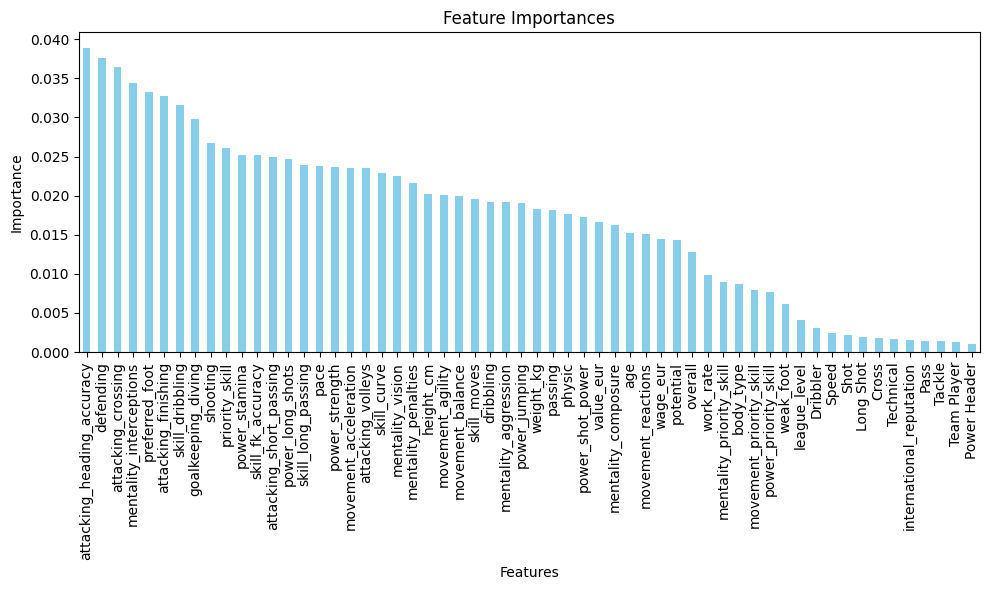

In [42]:
feature_importances = rf.feature_importances_
important_features = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
important_features.plot(kind='bar', color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

To have some insights on importance of features, we implemented such graph

### For opitmal choice of a configuration for RF model, we implemented this snippet to understand the trend of these different settings

Best configurations by F1 Score:
({'criterion': 'gini', 'max_depth': 16, 'n_estimators': 200}, 0.4005197524573193)
({'criterion': 'gini', 'max_depth': 14, 'n_estimators': 100}, 0.39669518965051087)
({'criterion': 'entropy', 'max_depth': 18, 'n_estimators': 200}, 0.39643576095954663)
({'criterion': 'gini', 'max_depth': 18, 'n_estimators': 200}, 0.3948406465421495)
({'criterion': 'entropy', 'max_depth': 14, 'n_estimators': 200}, 0.3944804307733884)


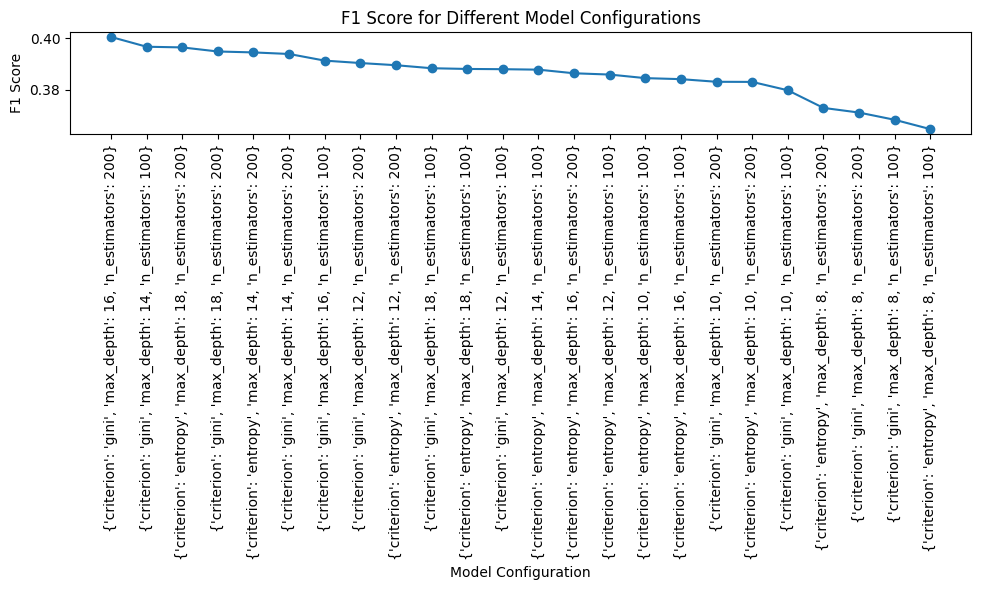

In [43]:
from sklearn.model_selection import train_test_split, ParameterGrid

param_grid = {
    'n_estimators': [i for i in range(100,300,100)],
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(8,20,2)]
}

grid = ParameterGrid(param_grid)
results = []

for params in grid:
    rf = RandomForestClassifier(**params, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append((params, f1))

results = sorted(results, key=lambda x: x[1], reverse=True)

print("Best configurations by F1 Score:")
for res in results[:5]:
    print(res)

params_list = [str(res[0]) for res in results]
f1_scores = [res[1] for res in results]

plt.figure(figsize=(10, 6))
plt.plot(range(len(f1_scores)), f1_scores, marker='o')
plt.xticks(range(len(params_list)), params_list, rotation=90)
plt.xlabel('Model Configuration')
plt.ylabel('F1 Score')
plt.title('F1 Score for Different Model Configurations')
plt.tight_layout()
plt.show()

# P.S. Insight about GK (Arguably)

## We had an idea, since GK caetgories the only one who have goalkeeping_speed feature to split the dataset and train it separatly. However, f1 seems to be less than our tradidtional approach

In [44]:
def calculate_goalkeeping_avg_by_position(data: pd.DataFrame) -> pd.DataFrame:
    goalkeeping_columns = [col for col in data.columns if col.startswith('goalkeeping')]
    
    grouped_data = data.groupby('position')[goalkeeping_columns].mean()
    
    return grouped_data


In [45]:
train_data = get_data("train")
positions = calculate_goalkeeping_avg_by_position(train_data)
positions

,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
position,,,,,,
CAM,10.482890,10.224335,10.520913,10.296578,10.623574,NaN
CB,10.904192,10.718563,10.694611,10.832335,10.592814,NaN
CDM,10.317881,10.364238,10.496689,10.715232,10.463576,NaN
CM,10.653333,10.693333,10.573333,10.600000,10.466667,NaN
GK,69.744849,67.326466,65.716323,68.695721,71.107765,40.220285
LB,10.507559,10.369330,10.455724,10.466523,10.598272,NaN
LCB,10.627575,10.416799,10.532488,10.678288,10.318542,NaN
LCM,10.425532,10.732861,10.304965,10.565012,10.286052,NaN
LDM,10.388060,10.651741,10.462687,10.343284,10.830846,NaN


In [46]:
train_data = get_data("train")

train_data_non_gk = train_data[train_data['goalkeeping_speed'].isna()]

train_data_non_gk = preprocess_data(train_data_non_gk, "train")

X = train_data_non_gk.drop("position", axis=1)
y = train_data_non_gk["position"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=200, criterion="gini", max_depth=16, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

f1 = f1_score(y_test, y_pred, average="weighted")

print(f1) 

Tranforming short_name (6090 unique values) to label columns
Tranforming club_name (701 unique values) to label columns
Tranforming league_name (55 unique values) to label columns
Tranforming nationality_name (144 unique values) to label columns
Tranforming preferred_foot (2 unique values) to label columns
Tranforming work_rate (9 unique values) to label columns
Tranforming body_type (10 unique values) to label columns
Tranforming real_face (2 unique values) to label columns
Tranforming player_traits (695 unique values) to label columns
Tranforming body_type_cleaned (4 unique values) to label columns
Tranforming priority_skill (5 unique values) to label columns
Tranforming movement_priority_skill (5 unique values) to label columns
Tranforming power_priority_skill (5 unique values) to label columns
Tranforming mentality_priority_skill (6 unique values) to label columns
Deleted 12 columns with corr > 0.9:
- release_clause_eur
- attacking_finishing
- skill_dribbling
- skill_ball_control
-

In [47]:
test_data = get_data("test")

ids = test_data["id"]

gk_mask = test_data["goalkeeping_speed"] > 40
gk_ids = test_data[gk_mask]["id"]

gk_predictions = pd.DataFrame({'id': gk_ids, 'position': 'GK'})

non_gk_data = test_data[~gk_mask]

non_gk_ids = non_gk_data["id"]

non_gk_data = preprocess_data(non_gk_data, "test")

missing_columns = X_train.columns.difference(non_gk_data.columns)
for col in missing_columns:
    non_gk_data[col] = 0 

non_gk_data = non_gk_data[X_train.columns]

predictions_non_gk = rf.predict(non_gk_data)

non_gk_predictions = pd.DataFrame({'id': non_gk_ids, 'position': predictions_non_gk})

output_df = pd.concat([gk_predictions, non_gk_predictions])

output_df = output_df.sort_values(by='id')

output_df.to_csv('submission_test.csv', index=False)

Tranforming short_name (722 unique values) to label columns
Tranforming club_name (467 unique values) to label columns
Tranforming league_name (52 unique values) to label columns
Tranforming nationality_name (82 unique values) to label columns
Tranforming preferred_foot (2 unique values) to label columns
Tranforming work_rate (9 unique values) to label columns
Tranforming body_type (10 unique values) to label columns
Tranforming real_face (2 unique values) to label columns
Tranforming player_traits (179 unique values) to label columns
Tranforming body_type_cleaned (4 unique values) to label columns
Tranforming priority_skill (6 unique values) to label columns
Tranforming movement_priority_skill (5 unique values) to label columns
Tranforming power_priority_skill (5 unique values) to label columns
Tranforming mentality_priority_skill (6 unique values) to label columns
Deleted 9 columns with corr > 0.9:
- release_clause_eur
- defending_marking_awareness
- defending_standing_tackle
- defen

/var/folders/_k/4jmlcdh94fn8f_g2j15scs2m0000gn/T/ipykernel_30930/3395839567.py:5: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  data["priority_skill"] = data[skill_pool].idxmax(axis=1)


### Ensuring other models are poor enough not to be testes

Tranforming short_name (6692 unique values) to label columns
Tranforming club_name (701 unique values) to label columns
Tranforming league_name (55 unique values) to label columns
Tranforming nationality_name (144 unique values) to label columns
Tranforming preferred_foot (2 unique values) to label columns
Tranforming work_rate (9 unique values) to label columns
Tranforming body_type (10 unique values) to label columns
Tranforming real_face (2 unique values) to label columns
Tranforming player_traits (773 unique values) to label columns
Tranforming body_type_cleaned (4 unique values) to label columns
Tranforming priority_skill (6 unique values) to label columns
Tranforming movement_priority_skill (5 unique values) to label columns
Tranforming power_priority_skill (5 unique values) to label columns
Tranforming mentality_priority_skill (6 unique values) to label columns
Deleted 12 columns with corr > 0.9:
- release_clause_eur
- skill_ball_control
- movement_sprint_speed
- mentality_posit

/var/folders/_k/4jmlcdh94fn8f_g2j15scs2m0000gn/T/ipykernel_30930/3395839567.py:5: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  data["priority_skill"] = data[skill_pool].idxmax(axis=1)


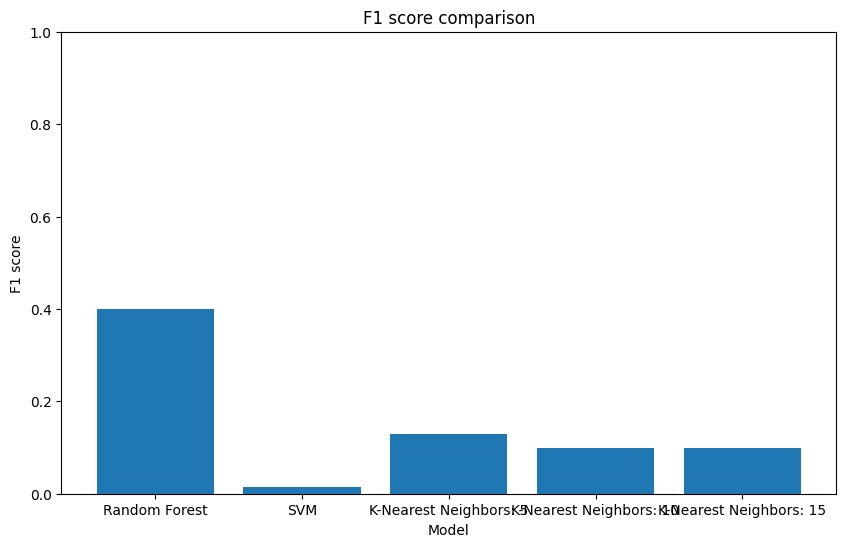

In [48]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

train_data = get_data("train")
train_data = preprocess_data(data=train_data, dataset_type="train")

X = train_data.drop("position", axis=1)
y = train_data["position"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, criterion="gini", max_depth=16, random_state=42),
    "SVM": SVC(kernel="rbf", random_state=42),
    "K-Nearest Neighbors: 5": KNeighborsClassifier(n_neighbors=5),
    "K-Nearest Neighbors: 10": KNeighborsClassifier(n_neighbors=10),
    "K-Nearest Neighbors: 15": KNeighborsClassifier(n_neighbors=15)
}

f1_scores = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average="weighted")
    f1_scores[model_name] = f1

plt.figure(figsize=(10, 6))
plt.bar(f1_scores.keys(), f1_scores.values())
plt.title("F1 score comparison")
plt.ylabel("F1 score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.show()